In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ase.io import read
from ase.visualize import view

In [2]:
molecules = read('data/dsgdb7njp.xyz@:')
print(len(molecules))

7211


In [3]:
[float(prop) for prop in molecules[0].info.keys()]

[-420.9337343048892,
 2.534576,
 2.43222,
 -14.1341,
 -10.9488,
 -16.013,
 1.087,
 0.1323,
 4.162,
 15.72523,
 -3.98613,
 36.7680730972,
 39.6946262426,
 0.621841405]

In [7]:
from dscribe.descriptors import SOAP, MBTR

def dataloader_MBTR(molecules,normalization="none"):
    # Setup
    mbtr = MBTR(
        species=["H", "C", "O", "N", "S", "Cl"],
        k2={
        "geometry": {"function": "inverse_distance"},
        "grid": {"min": 0, "max": 2.0, "n": 100, "sigma": 0.1},
        "weighting": {"function": "exp", "scale": 0.5, "threshold": 1e-3},
        },
        periodic=False,
        normalization=normalization,
    )

    return mbtr.create(molecules)
    
def dataloader_SOAP(molecules,average='off'):
    species = ["H", "C", "O", "N", "S", "Cl"]
    rcut = 4.0
    nmax = 8
    lmax = 3

    # Setting up the SOAP descriptor
    soap = SOAP(
        species=species,
        periodic=False,
        rcut=rcut,
        nmax=nmax,
        lmax=lmax,
        average=average
    )
    
    return soap.create(molecules)

    
def dataloader_properties(molecules):
#01 ae_pbe0    kcal/mol   Atomization energy (DFT/PBE0)
#02 p_pbe0     Angstrom^3 Polarizability (DFT/PBE0)
#03 p_scs      Angstrom^3 Polarizability (self-consistent screening)
#04 homo_gw    eV         Highest occupied molecular orbital (GW)
#05 homo_pbe0  eV         Highest occupied molecular orbital (DFT/PBE0)
#06 homo_zindo eV         Highest occupied molecular orbital (ZINDO/s)
#07 lumo_gw    eV         Lowest unoccupied molecular orbital (GW)
#08 lumo_pbe0  eV         Lowest unoccupied molecular orbital (DFT/PBE0)
#09 lumo_zindo eV         Lowest unoccupied molecular orbital (ZINDO/s)
#10 ip_zindo   eV         Ionization potential (ZINDO/s)
#11 ea_zindo   eV         Electron affinity (ZINDO/s)
#12 e1_zindo   eV         First excitation energy (ZINDO)
#13 emax_zindo eV         Maximal absorption intensity (ZINDO)
#14 imax_zindo arbitrary  Excitation energy at maximal absorption (ZINDO)

#I. = Index, DFT/PBE0 = density functional theory with PBE0 functional,
#GW = Hedin's GW approximation, ZINDO = Zerner's intermediate neglect of 
#differential overlap. Divide ae_pbe0 by 23.045108 to convert to eV.
    AEs      = []
    HOMOs_gw = []
    IP_zindo = []
    N_atoms  = []
    p_pbe0   = []
    for mol in molecules:
        props = [float(prop) for prop in mol.info.keys()]
        AEs.append(props[0])
        HOMOs_gw.append(props[3])
        IP_zindo.append(props[9])
        N_atoms.append(len(mol))
        p_pbe0.append(props[1])
    return np.array([np.array(AEs),np.array(HOMOs_gw),np.array(IP_zindo),np.array(N_atoms),np.array(AEs)/np.array(N_atoms),np.array(p_pbe0)]).T

In [8]:
properties = dataloader_properties(molecules)
print(properties.shape)

(7211, 6)


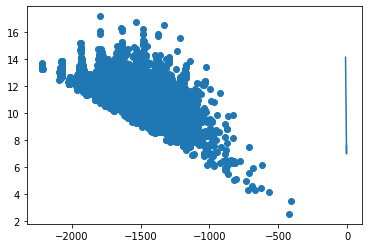

In [9]:
plt.scatter(properties[:,0],properties[:,5])
plt.plot(properties[:,1],-properties[:,1])

In [23]:
# Note that this step takes a while because MBTR is slow for many species...
mbtr_nonorm = dataloader_MBTR(molecules,normalization='none')
mbtr_norm   = dataloader_MBTR(molecules,normalization='l2_each')

In [24]:
print(mbtr_nonorm.shape)
#print(atomic_soap.shape)

(7211, 2700)


In [25]:
from sklearn.model_selection import train_test_split

def data_splitter(X,Y,train_size=1000):
    X_train, X_valtest, Y_train, Y_valtest = train_test_split(X, Y, train_size=train_size, random_state=42)
    X_val, X_test, Y_val, Y_test = train_test_split(X_valtest, Y_valtest, train_size=1000, random_state=42)
    return X_train, Y_train, X_val, Y_val, X_test, Y_test

def data_splitter_indices(X,Y,train_size=1000):
    ntotal = len(Y)
    idx = np.arange(ntotal)
    rng = np.random.default_rng()
    rng.shuffle(idx)
    
    return idx[:train_size], idx[train_size:train_size+1000], idx[train_size+1000:]

In [26]:
from sklearn.linear_model import Ridge

In [47]:
#X_train, Y_train, X_val, Y_val, X_test, Y_test = data_splitter(average_soap,properties[:,0],train_size=5000) # atomization energies
idx_train, idx_val, idx_test = data_splitter_indices(mbtr_nonorm,properties[:,0],train_size=1000)
print(idx_test)

[3691  532 3251 ... 3787 5401  810]


In [48]:
N_train = 1000
iprop = 0

X_train = mbtr_nonorm[idx_train[:N_train]]
Y_train = properties[:,iprop][idx_train[:N_train]]
mean_Y = np.mean(Y_train)
sig_Y  = np.std(Y_train)
print(mean_Y,sig_Y)
Y_train_std = (Y_train-mean_Y)/sig_Y
X_val = mbtr_nonorm[idx_val]
Y_val = properties[:,iprop][idx_val]
X_test = mbtr_nonorm[idx_test]
Y_test = properties[:,iprop][idx_test]

-1564.1482090627812 227.46634019993508


In [32]:
for reg in np.logspace(-6,-1,8):
    ridge_regressor = Ridge(alpha=reg)
    res = ridge_regressor.fit(X_train,Y_train)
    Y_pred = ridge_regressor.predict(X_val)
    print(np.mean(np.abs(Y_val-Y_pred)))

3.133483303213492
3.051885074310836
3.040902157254016
3.025692758314062
3.0245948840094328
3.0399034542387304
3.05555077330709
3.0411278889503337


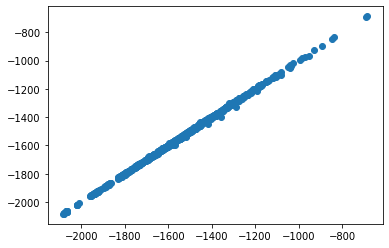

In [33]:
plt.scatter(Y_val,Y_pred)

In [49]:
N_train = 1000
iprop = 0

X_train = mbtr_norm[idx_train[:N_train]]
Y_train = properties[:,iprop][idx_train[:N_train]]
mean_Y = np.mean(Y_train)
sig_Y  = np.std(Y_train)
print(mean_Y,sig_Y)
Y_train_std = (Y_train-mean_Y)/sig_Y
X_val = mbtr_norm[idx_val]
Y_val = properties[:,iprop][idx_val]
X_test = mbtr_norm[idx_test]
Y_test = properties[:,iprop][idx_test]

-1564.1482090627812 227.46634019993508


In [35]:
for reg in np.logspace(-6,-1,8):
    ridge_regressor = Ridge(alpha=reg)
    res = ridge_regressor.fit(X_train,Y_train)
    Y_pred = ridge_regressor.predict(X_val)
    print(np.mean(np.abs(Y_val-Y_pred)))

18.05988923611999
18.07269527016319
17.885486396021275
18.42039479408082
19.915713981135465
22.825223269045356
27.571573786181034
35.817660024118126


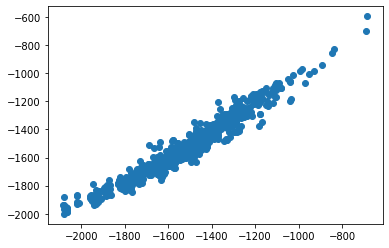

In [36]:
plt.scatter(Y_val,Y_pred)

In [54]:
from sklearn.kernel_ridge import KernelRidge

for reg in np.logspace(-8,-6,5):
    for gamma in np.logspace(-3,-0,20):
        krr_regressor = KernelRidge(alpha=reg,kernel='rbf',gamma=gamma)
    #krr_regressor = KernelRidge(alpha=reg,kernel='polynomial',coef0=1.,degree=2)
        res = krr_regressor.fit(X_train,Y_train)
        Y_pred = krr_regressor.predict(X_val)
        print(reg,gamma,np.mean(np.abs(Y_val-Y_pred)))

1e-08 0.001 10.180807939436738
1e-08 0.0014384498882876629 9.243401530465137
1e-08 0.00206913808111479 8.56713566566359
1e-08 0.002976351441631319 8.0995894673105
1e-08 0.004281332398719396 7.7714799215036585
1e-08 0.006158482110660267 7.507368558935465
1e-08 0.008858667904100823 7.243709988934516
1e-08 0.012742749857031334 7.110399465277315
1e-08 0.018329807108324356 7.121628647737751
1e-08 0.026366508987303583 7.318048549838821
1e-08 0.0379269019073225 7.765279754447687
1e-08 0.05455594781168517 8.34907896586204
1e-08 0.07847599703514611 9.197901074841054
1e-08 0.11288378916846883 10.4760596885338
1e-08 0.1623776739188721 12.053114235894773
1e-08 0.23357214690901212 13.506933926604889
1e-08 0.3359818286283781 14.545171223133
1e-08 0.4832930238571752 15.158376581386575
1e-08 0.6951927961775606 15.51827413581283
1e-08 1.0 15.632534599825327
3.162277660168379e-08 0.001 12.150132923187208
3.162277660168379e-08 0.0014384498882876629 10.868619556609197
3.162277660168379e-08 0.0020691380811

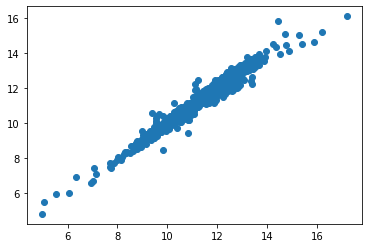

In [157]:
plt.scatter(Y_val,Y_pred)

In [161]:
def build_kernel(soap1,soap2,degree=2,mode='average'):
    n1 = len(soap1)
    n2 = len(soap2)
    K = np.zeros((n1,n2))
    for i in range(n1):
        if mode == 'average':
            frac1 = 1./len(soap1[i])
        else:
            frac1 = 1.
        for j in range(n2):
            if mode == 'average':
                frac2 = 1./len(soap2[j])
            else:
                frac2 = 1.
            for s1 in soap1[i]:
                for s2 in soap2[j]:
                    K[i,j] += frac1*frac2*np.dot(s1,s2)**degree
    return K

In [162]:
K_train = build_kernel(atomic_soap,atomic_soap)

KeyboardInterrupt: 